# INTRODUCTION 

This notebook will aim to provide an explanation and application of different feature ranking methods, namely that of Recursive Feature Elimination (RFE), Stability Selection, linear models as well as Random Forest.

This notebook borrows heavily from an article by Ando Saabas on feature selection found here: http://blog.datadive.net/selecting-good-features-part-iv-stability-selection-rfe-and-everything-side-by-side/ as well as Anisotropic's work on feature selection found here: https://www.kaggle.com/arthurtok/feature-ranking-w-randomforest-rfe-linear-models/code.  A lot of Anisotropic's comments are used in this kernel to explain what is being done.

My work is an application of the techniques and methods written by those gentlemen to the Zillow data competition. I have included additional competition specific data cleaning and comments in addition to the feature selection code.

The contents of this notebook are as follows: 

 1. **Data Cleaning and Visualisation** : This section will revolve around exploring the data and visualising some summary statistics. 
 2. **Stability Selection via Randomised Lasso Method** : Introduce a relatively new feature selection method called "Stability Selection" and using the Randomised Lasso in its implementation
 3. **Recursive Feature Elimination** : Implementing the Recursive Feature Elimination method of feature ranking via the use of basic Linear Regression 
 4. **Linear Model Feature Coefficients** : Implementing 3 of Sklearn's linear models (Linear Regression, Lasso and Ridge) and using the inbuilt estimated coefficients for our feature selection
 5. **Random Forest Feature Selection** : Using the Random Forest's convenient attribute "feature_importances" to calculate and ultimately rank the feature importance.

Finally, with all the points 1 to 5 above, we will combine the results to create our:

**Feature Ranking Matrix** : Matrix of all the features along with the respective model scores which we can use in our ranking.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, RandomizedLasso)
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

# 1. DATA CLEANSING AND ANALYSIS

Let's first read in the house data as a dataframe "house" and inspect the first 5 rows

In [2]:
# Load Data
train = pd.read_csv('../input/train_2016_v2.csv')
prop = pd.read_csv('../input/properties_2016.csv')

# Convert to float32
for c, dtype in zip(prop.columns, prop.dtypes):
    if dtype == np.float64:
        prop[c] = prop[c].astype(np.float32)

# Merge training dataset with properties dataset
df_train = train.merge(prop, how='left', on='parcelid')

# Remove ID columns
x_train = df_train.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 'propertycountylandusecode'], axis=1)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
x_train.head()

,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,1.0,NaN,NaN,2.0,3.0,NaN,4.0,2.0,NaN,NaN,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.879883,NaN,NaN,6.037107e+13
1,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.019531,NaN,NaN,NaN
2,1.0,NaN,NaN,3.0,2.0,NaN,4.0,3.0,NaN,NaN,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.480469,NaN,NaN,6.037464e+13
3,1.0,NaN,NaN,2.0,2.0,NaN,4.0,2.0,NaN,NaN,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.739990,NaN,NaN,6.037296e+13
4,NaN,NaN,NaN,2.5,4.0,NaN,NaN,2.5,NaN,NaN,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.959961,NaN,NaN,6.059042e+13


Now its time for some general data inspection. Let's first examine to see if there are any nulls in the dataframe as well as look at the type of the data (i.e whether it is a string or numeric)

In [4]:
print(x_train.dtypes)

airconditioningtypeid           float32
architecturalstyletypeid        float32
basementsqft                    float32
bathroomcnt                     float32
bedroomcnt                      float32
buildingclasstypeid             float32
buildingqualitytypeid           float32
calculatedbathnbr               float32
decktypeid                      float32
finishedfloor1squarefeet        float32
calculatedfinishedsquarefeet    float32
finishedsquarefeet12            float32
finishedsquarefeet13            float32
finishedsquarefeet15            float32
finishedsquarefeet50            float32
finishedsquarefeet6             float32
fips                            float32
fireplacecnt                    float32
fullbathcnt                     float32
garagecarcnt                    float32
garagetotalsqft                 float32
hashottuborspa                   object
heatingorsystemtypeid           float32
latitude                        float32
longitude                       float32


I'll see what values are in the object type columns -- We will have to either break these features up so that for each option there is just a binary (True / False) indicator, or find a way to make the existing features binary.

In [5]:
x_train['taxdelinquencyflag'].value_counts()

Y    1783
Name: taxdelinquencyflag, dtype: int64

In [6]:
x_train['fireplaceflag'].value_counts()

True    222
Name: fireplaceflag, dtype: int64

In [7]:
x_train['hashottuborspa'].value_counts()

True    2365
Name: hashottuborspa, dtype: int64

I'll have to convert the 'Y' to a TRUE and otherwise convert any NaN to False's

In [8]:
x_train['taxdelinquencyflag'] = x_train['taxdelinquencyflag'] == 'Y'

In [9]:
for c in x_train.dtypes[x_train.dtypes == object].index.values:
    x_train[c] = (x_train[c] == True)

In [10]:
# Looking for nulls
print(x_train.isnull().sum())

airconditioningtypeid           61494
architecturalstyletypeid        90014
basementsqft                    90232
bathroomcnt                         0
bedroomcnt                          0
buildingclasstypeid             90259
buildingqualitytypeid           32911
calculatedbathnbr                1182
decktypeid                      89617
finishedfloor1squarefeet        83419
calculatedfinishedsquarefeet      661
finishedsquarefeet12             4679
finishedsquarefeet13            90242
finishedsquarefeet15            86711
finishedsquarefeet50            83419
finishedsquarefeet6             89854
fips                                0
fireplacecnt                    80668
fullbathcnt                      1182
garagecarcnt                    60338
garagetotalsqft                 60338
hashottuborspa                      0
heatingorsystemtypeid           34195
latitude                            0
longitude                           0
lotsizesquarefeet               10150
poolcnt     

Yikes, the data is pretty sparse.  We're going to have to figure out how to either remove some features or impute values for some of these.

Temporarily I'll be imputing averages for the missing values based on the missing value for said column, but its only a stopgap solution before I can do something else (possibly predict missing values?)

In [11]:
x_train = x_train.fillna(x_train.mean())

# 2. Stability Selection via Randomized Lasso

In a nutshell, this method serves to apply the feature selection on different parts of the data and features repeatedly until the results can be aggregated. Therefore stronger features ( defined as being selected as important) will have greater scores in this method as compared to weaker features. Refer to this paper by Nicolai Meinshausen and Peter Buhlmann for a much greater detail on the method : http://stat.ethz.ch/~nicolai/stability.pdf

In this notebook, the Stability Selection method is conveniently inbuilt into sklearn's randomized lasso model and therefore this will be implemented as follows:

In [12]:
# First extract the target variable which is our Log Error
Y = df_train['logerror'].values
X = x_train.as_matrix()

# Store the column/feature names into a list "colnames"
colnames = x_train.columns

Next, we create a function which will be able to conveniently store our feature rankings obtained from the various methods described here into a Python dictionary. In case you are thinking I created this function, no this is not the case. All credit goes to Ando Saabas and I am only trying to apply what he has discussed in this context.

In [13]:
# Define dictionary to store our rankings
ranks = {}
# Create our function which stores the feature rankings to the ranks dictionary
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

In [14]:
# Finally let's run our Selection Stability method with Randomized Lasso
rlasso = RandomizedLasso(alpha=0.04)
rlasso.fit(X, Y)
ranks["rlasso/Stability"] = ranking(np.abs(rlasso.scores_), colnames)
print('finished')

finished


# 3. Recursive Feature Elimination ( RFE )

Now onto the next method in our feature ranking endeavour. Recursive Feature Elimination or RFE uses a model ( eg. linear Regression or SVM) to select either the best or worst-performing feature, and then excludes the feature. After this, the whole process is iterated until all features in the dataset are used up ( or up to a user-defined limit). Sklearn conveniently possesses a RFE function via the sklearn.feature_selection call and we will use this along with a simple linear regression model for our ranking search as follows:

In [15]:
# Construct our Linear Regression model
lr = LinearRegression(normalize=True)
lr.fit(X,Y)
#stop the search when only the last feature is left
rfe = RFE(lr, n_features_to_select=1, verbose =3 )
rfe.fit(X,Y)
ranks["RFE"] = ranking(list(map(float, rfe.ranking_)), colnames, order=-1)

Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 fe

# 4. Linear Model Feature Ranking

Now let's apply 3 different linear models (Linear, Lasso and Ridge Regression) and how the features are selected and prioritised via these models. To achieve this, I shall use the sklearn implementation of these models and in particular the attribute .coef to return the estimated coefficients for each feature in the linear model.

In [16]:
# Using Linear Regression
lr = LinearRegression(normalize=True)
lr.fit(X,Y)
ranks["LinReg"] = ranking(np.abs(lr.coef_), colnames)

# Using Ridge 
ridge = Ridge(alpha = 7)
ridge.fit(X,Y)
ranks['Ridge'] = ranking(np.abs(ridge.coef_), colnames)

# Using Lasso
lasso = Lasso(alpha=.05)
lasso.fit(X, Y)
ranks["Lasso"] = ranking(np.abs(lasso.coef_), colnames)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


# 5. Random Forest feature ranking

Sklearn's Random Forest model also comes with it's own inbuilt feature ranking attribute and one can conveniently just call it via "feature_importances_". That is what we will be using as follows:

In [17]:
rf = RandomForestRegressor(n_jobs=-1, n_estimators=50, verbose=2)
rf.fit(X,Y)
ranks["RF"] = ranking(rf.feature_importances_, colnames)

building tree 1 of 50building tree 2 of 50building tree 3 of 50building tree 4 of 50building tree 5 of 50building tree 6 of 50building tree 7 of 50building tree 8 of 50building tree 9 of 50building tree 10 of 50building tree 11 of 50building tree 12 of 50building tree 13 of 50building tree 14 of 50building tree 15 of 50building tree 16 of 50















building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50

[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   40.7s



building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  45 out of  50 | elapsed:  2.0min remaining:   13.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.1min finished


# 6. Creating the Feature Ranking Matrix

We combine the scores from the various methods above and output it in a matrix form for convenient viewing as such:

In [18]:
# Create empty dictionary to store the mean value calculated from all the scores
r = {}
for name in colnames:
    r[name] = round(np.mean([ranks[method][name] 
                             for method in ranks.keys()]), 2)
 
methods = sorted(ranks.keys())
ranks["Mean"] = r
methods.append("Mean")

print("\t%s" % "\t".join(methods))
for name in colnames:
    print("%s\t%s" % (name, "\t".join(map(str, 
                         [ranks[method][name] for method in methods]))))

	Lasso	LinReg	RF	RFE	Ridge	rlasso/Stability	Mean
airconditioningtypeid	0.0	0.01	0.08	0.72	0.01	0.0	0.14
architecturalstyletypeid	0.0	0.01	0.0	0.69	0.01	0.0	0.12
basementsqft	0.0	0.0	0.0	0.63	0.0	0.0	0.1
bathroomcnt	0.0	0.34	0.1	0.85	0.36	0.0	0.27
bedroomcnt	0.0	0.03	0.21	0.83	0.03	0.0	0.18
buildingclasstypeid	0.0	0.0	0.0	0.13	0.0	0.0	0.02
buildingqualitytypeid	0.0	0.01	0.11	0.59	0.01	0.0	0.12
calculatedbathnbr	0.0	0.21	0.1	0.89	0.23	0.0	0.24
decktypeid	0.0	0.0	0.0	0.07	0.0	0.0	0.01
finishedfloor1squarefeet	0.0	0.0	0.05	0.52	0.0	0.0	0.1
calculatedfinishedsquarefeet	0.0	0.0	0.59	0.39	0.0	0.0	0.16
finishedsquarefeet12	1.0	0.0	0.56	0.48	0.0	0.0	0.34
finishedsquarefeet13	0.0	0.0	0.0	0.61	0.0	0.0	0.1
finishedsquarefeet15	0.46	0.0	0.13	0.41	0.0	0.0	0.17
finishedsquarefeet50	0.13	0.0	0.06	0.5	0.0	0.0	0.12
finishedsquarefeet6	0.02	0.0	0.03	0.46	0.0	0.0	0.08
fips	0.0	0.17	0.01	0.65	0.18	0.0	0.17
fireplacecnt	0.0	0.11	0.03	0.96	0.11	0.0	0.2
fullbathcnt	0.0	0.07	0.07	0.8	0.07	0.0	0.17
garagecarcnt

Now, with the matrix above, the numbers and layout does not seem very easy or pleasant to the eye. Therefore, let's just collate the mean ranking score attributed to each of the feature and plot that via Seaborn's factorplot.

In [19]:
# Put the mean scores into a Pandas dataframe
meanplot = pd.DataFrame(list(r.items()), columns= ['Feature','Mean Ranking'])

# Sort the dataframe
meanplot = meanplot.sort_values('Mean Ranking', ascending=False)

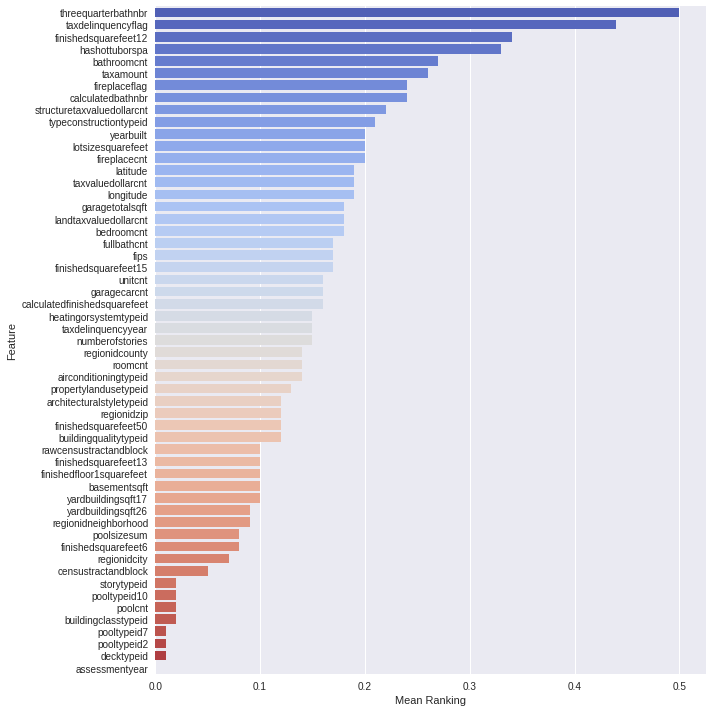

In [20]:
# Let's plot the ranking of the features
sns.factorplot(x="Mean Ranking", y="Feature", data = meanplot, kind="bar", size=10, aspect=1, palette='coolwarm')

# Conclusion

The top 3 features are "Three Quarter Bathroom Count", "Finished Square Feet", and "Tax Delinquincy Flag".  "Tax amount" and "Has Hot Tub or Spa" are 4th and 5th.

I'm concerned that the 3/4 bathroom count is listed so highly- that feature is null for about 80% of the scenarios. It also doesn't have an intuitive explanation for why it'd impact the sell price.  On the other hand, square footage, hot tub or spa presence, and tax amount are all very intuitive features that we'd expect to do well.

My biggest concern is that there are so many nulls in my training set and that simply imputing the average is not a proper solution.  